# SentiLens - Uncover reviews' hidden emotion
Created by: Tina Vu
Created on: 20231001 

Employing aspect-based sentiment analysis (ABSA) to extract valuable feature insights from e-commerce product reviews, thereby empowering consumers to make more informed purchasing decisions and enhancing their overall user experience on the platform.

Utilizing manually annotated reviews for aspect sentiment analysis to extract aspects and predict sentiments from reviews. This enables consumers to obtain a condensed overview of sentiments related to various product features, eliminating the need to delve into an extensive array of reviews. As a result, the decision-making process becomes more streamlined and user-friendly.

__Approach:__

ABSA

# Exploratory data analysis
Data source:

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re 
from collections import Counter

from wordcloud import WordCloud

# import nltk
# from nltk.tokenize import word_tokenize

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Set Pandas to display all columns without truncation
pd.options.display.max_columns = None
# Set Pandas to display all full length of a column
pd.set_option('display.max_colwidth', None)

/Users/tina.vu/work/fun/brainstation_capstone_env/test/test_capstone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-14 04:47:24.651318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0. Import data
The dataset is really small due to very limited annotated data available publicly. I hope to use this dataset to learn and develop the model and then apply `transfer learning` to predict the `aspect based sentiment analysis (ABSA)` on the overall `Amazon Reviews`

### 0.1. Annotated data to train model
The data used is from Semeval-ABSA / laptop

Load dataset `semeval-absa/laptop` from `Hugging Face`

In [2]:
dataset = load_dataset("jakartaresearch/semeval-absa", 'laptop')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 3048
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 800
    })
})

There are two splits of data: 
- Train: 3,048 rows
- Validation: 800 rows

The dataset is really small due to very limited annotated data available publicly. I hope to use this dataset to learn and develop the model and then apply `transfer learning` to predict the `aspect based sentiment analysis (ABSA)` on the overall `Amazon Reviews`

The dataset includes 3 columns:
- __id__: Review's unique identifier
- __text__: Review's content
- __aspects__: List of terms and their polarity, and location of the term in the index (from and to index)

In [3]:
dataset.set_format(type='pandas')
df = dataset['train'][:]
df.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}"
1,812,I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
2,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}"
3,2328,I investigated netbooks and saw the Toshiba NB305-N410BL.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
4,2193,"The other day I had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.","{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"


Let's check for duplicates in the data.

In [4]:
df.duplicated(subset=['text']).sum()

12

There are 12 records that are duplicated on `text`. Let's examine them.

In [5]:
df[df.duplicated(subset=['text'], keep=False)].sort_values(by='text')

,id,text,aspects
2986,461,A tip for people looking into this computer: DO NOT BUY IT save up a bit more money and buy a computer that will last.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
2492,1132,A tip for people looking into this computer: DO NOT BUY IT save up a bit more money and buy a computer that will last.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
2459,1130,After replacing the hard drive the battery stopped working (3 months of use) which was frustrating.,"{'term': ['hard drive', 'battery'], 'polarity': ['neutral', 'negative'], 'from': [20, 35], 'to': [30, 42]}"
1835,459,After replacing the hard drive the battery stopped working (3 months of use) which was frustrating.,"{'term': ['hard drive', 'battery'], 'polarity': ['neutral', 'negative'], 'from': [20, 35], 'to': [30, 42]}"
2092,22,Ease of use is just one of the benefits I love about my Mac.,"{'term': ['use'], 'polarity': ['positive'], 'from': [8], 'to': [11]}"
2391,670,Ease of use is just one of the benefits I love about my Mac.,"{'term': ['use'], 'polarity': ['positive'], 'from': [8], 'to': [11]}"
1321,1114,Enough said.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
1612,1125,Enough said.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
1029,75,I love it!,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"
2520,690,I love it!,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}"


All duplicates are the same, we can drop the duplicates from this dataset.

In [6]:
df.drop_duplicates(subset=['text'], inplace=True)

## 1. Denormalize the dataset
Since `aspects` is a stacked of multiple aspects and their information. I will flatten each item from aspects into separated rows, while maintaining other information of the text.

In [7]:
def flatten_term_pairs(aspects):
  '''
  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: json array
    term: string array
    polarity: string array
    from: integer array
    to: integer array

    For example:
      {
        'term': ['cord', 'battery life'], 
        'polarity': ['neutral', 'positive'], 
        'from': [41, 74],
        'to': [45, 86]
      }
      
  Output:
  - PAIRS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  '''
  pairs=list()
  l = len(aspects['term'])

  for i in range(0,l):
    pairs.append(dict({'term': aspects['term'][i]
                       ,'polarity':aspects['polarity'][i]
                       , 'term_start':aspects['from'][i]
                       , 'term_end':aspects['to'][i]}))
  return pairs

# Transform aspects from dictionary of array into array of dictionary
df['pairs'] = df.apply(lambda x: flatten_term_pairs(x['aspects']), axis=1)

# Flatten pairs into multiple records
df = df.explode('pairs').reset_index(drop=True)

# Extract values from the dictionary in pairs
df['term'] = df['pairs'].apply(lambda x: x['term'])
df['polarity'] = df['pairs'].apply(lambda x: x['polarity'])
df['term_start'] = df['pairs'].apply(lambda x: x['term_start'])
df['term_end'] = df['pairs'].apply(lambda x: x['term_end'])

# Replace empty string to None
df.replace('', None, inplace=True)

df.head()

,id,text,aspects,pairs,term,polarity,term_start,term_end
0,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}","{'term': 'cord', 'polarity': 'neutral', 'term_start': 41, 'term_end': 45}",cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}","{'term': 'battery life', 'polarity': 'positive', 'term_start': 74, 'term_end': 86}",battery life,positive,74,86
2,812,I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}","{'term': '', 'polarity': '', 'term_start': 0, 'term_end': 0}",None,None,0,0
3,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}","{'term': 'service center', 'polarity': 'negative', 'term_start': 27, 'term_end': 41}",service center,negative,27,41
4,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}","{'term': '""sales"" team', 'polarity': 'negative', 'term_start': 109, 'term_end': 121}","""sales"" team",negative,109,121


Now for each review text, there is only one aspect per record. This will be easier for us to perform EDA.

Let's have a check to make sure all aspects were flatten correctly by checking the length of terms and total of records per review.

In [8]:
# Calculate length of term in aspects
df['term_length'] = df['aspects'].apply(lambda x: len([k for k in x['term'] if k != ''])) # Do not count empty string element

# Calculate avg of term count and count total records per id
res = df.groupby('id').agg({'term': 'count', 'term_length': 'mean'})

# List any ids that have different term counts and term_length
if len(res[res['term'] != res['term_length']]) == 0:
  print('\033[92mTEST PASSED: # of records per text is the same as number of terms per text.')
else:
  print(f'\033[91mTEST FAILED: # of records per text is the same as number of terms per text.')

TEST PASSED: # of records per text is the same as number of terms per text.


There is no violations which indicates the data is flatten correctly.
Let's drop those temporary columns that are not useful anymore.

In [9]:
df.drop(columns=['pairs','term_length'], axis=1, inplace=True)
df.head()

,id,text,aspects,term,polarity,term_start,term_end
0,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",battery life,positive,74,86
2,812,I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
3,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}",service center,negative,27,41
4,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}","""sales"" team",negative,109,121


# 2. Dataset overview

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3912 non-null   object
 1   text        3912 non-null   object
 2   aspects     3912 non-null   object
 3   term        2362 non-null   object
 4   polarity    2362 non-null   object
 5   term_start  3912 non-null   int16 
 6   term_end    3912 non-null   int16 
dtypes: int16(2), object(5)
memory usage: 168.2+ KB


In [11]:
df.isna().sum()

id               0
text             0
aspects          0
term          1550
polarity      1550
term_start       0
term_end         0
dtype: int64

There are 1,556 records (text) that have 0 term. 
Let's look into these.

In [12]:
df[df['term'].isna()]

,id,text,aspects,term,polarity,term_start,term_end
2,812,I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
6,2328,I investigated netbooks and saw the Toshiba NB305-N410BL.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
7,2193,"The other day I had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.","{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
13,425,Sad very SAD.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
18,747,Needless to say a PC that can't support a cell phone is less than useless!,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
...,...,...,...,...,...,...,...
3907,611,The latest and mightiest Macbook pro 17-inch was bought by my university on the 30th of June 2009.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
3908,1195,I have a business website and every time I have to change something I have to go to the public library to use a PC.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
3909,2893,I paid about the same for my Toshiba as I did for the compaq a few years back.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0
3910,1712,This was an update from an early MacBook Pro.,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0


In [13]:
df[df['term'].isna() == False]

,id,text,aspects,term,polarity,term_start,term_end
0,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",battery life,positive,74,86
3,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}",service center,negative,27,41
4,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}","""sales"" team",negative,109,121
5,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}",tech guy,neutral,4,12
...,...,...,...,...,...,...,...
3896,2272,"We also use Paralles so we can run virtual machines of Windows XP Professional, Windows 7 Home Premium, Windows Server Enterprise 2003, and Windows Server 2008 Enterprise.","{'term': ['Paralles', 'Windows XP Professional', 'Windows 7 Home Premium', 'Windows Server Enterprise 2003', 'Windows Server 2008 Enterprise'], 'polarity': ['neutral', 'neutral', 'neutral', 'neutral', 'neutral'], 'from': [12, 55, 80, 104, 140], 'to': [20, 78, 102, 134, 170]}",Windows Server Enterprise 2003,neutral,104,134
3897,2272,"We also use Paralles so we can run virtual machines of Windows XP Professional, Windows 7 Home Premium, Windows Server Enterprise 2003, and Windows Server 2008 Enterprise.","{'term': ['Paralles', 'Windows XP Professional', 'Windows 7 Home Premium', 'Windows Server Enterprise 2003', 'Windows Server 2008 Enterprise'], 'polarity': ['neutral', 'neutral', 'neutral', 'neutral', 'neutral'], 'from': [12, 55, 80, 104, 140], 'to': [20, 78, 102, 134, 170]}",Windows Server 2008 Enterprise,neutral,140,170
3902,848,"How Toshiba handles the repair seems to vary, some folks indicate that they were charged for even an intial fix, others had the repair done 5 times.","{'term': ['repair', 'repair'], 'polarity': ['conflict', 'positive'], 'from': [24, 130], 'to': [30, 136]}",repair,conflict,24,30
3903,848,"How Toshiba handles the repair seems to vary, some folks indicate that they were charged for even an intial fix, others had the repair done 5 times.","{'term': ['repair', 'repair'], 'polarity': ['conflict', 'positive'], 'from': [24, 130], 'to': [30, 136]}",repair,positive,130,136


It looks like those that do not have any term either do not have any `noun` in their text (id 425: Sad very SAD.) or have very `generic nouns` for the subject (id 2982: something, my opinon) or have terms `without polarity` (id 2328: Netbooks, Toshiba...).

We will examine these later, as this seem to be quite a large number (1/3 of total records we have now, but this is actually more, as we have duplicated text here due to multi-terms per text). For now, I think these records are very important for the algorithm to learn and have an output option as None which would be better than forcing the algorithm to always have to return a term for a given text, as text (reviews) without actual term / term with polarity do exist in practice.

Final sanity checks on term start and term end to make sure they follow what we expect.
1. 0 term text should have term start & term end both equal 0
2. Other text with at least one term, the difference between term start and term end should be equal to term length

In [14]:
# 1. 0 term text should have term start & term end both equal 0
if len(df[(df['term'].isna()) & ((df['term_start'] != 0)  | (df['term_end'] != 0)) ] ) == 0:
  print('\033[92m TEST PASSED: All 0 term text have both term start and term end both equal 0.')
else:
  print('\033[91m TEST FAILED: All 0 term text have both term start and term end both equal 0.')

 TEST PASSED: All 0 term text have both term start and term end both equal 0.


In [15]:
# 2. Other text with at least one term, the difference between term start and term end should be equal to term length
if len(df[(df['term'].isna() == False) & (df['term_end'] - df['term_start'] != df['term'].str.len())]) == 0:
  print('\033[92m TEST PASSED: All terms has the same length as the difference between term start and term end.')
else:
  print('\033[91m TEST FAILED: All terms has the same length as the difference between term start and term end.')

 TEST PASSED: All terms has the same length as the difference between term start and term end.


# 2. Polarity

## 2.1. Terms per polarity 

In [16]:
# Calculate term counts per polarity & sort by count desc
polarity_counts = df.groupby('polarity').agg({'id':'count'}).sort_values('id', ascending=False).reset_index()

polarity_counts['pct'] = polarity_counts['id'] / len(df) * 100

fig = px.bar(polarity_counts, y='pct', x='polarity', title='Number of terms per polarity', width=800, height=400)
fig.show()

We have pretty balanced data between positive and negative terms, and not very few neutral terms, however, conflict polarity is really small which may be difficult to predict but these also do exist in practice. I was thinking of combining conflict and neutral in one group as `other`, however, after examining some examples from these two groups, I decided to combine `conflict` with `positive` as it does look like people are okay with the problems identified which as a result is a positive thing.

In [17]:

df[df['polarity'] == 'neutral'].head()

,id,text,aspects,term,polarity,term_start,term_end
0,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",cord,neutral,41,45
5,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}",tech guy,neutral,4,12
23,917,"One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.","{'term': ['GUI', 'screen', 'power light', 'hard drive ligh'], 'polarity': ['negative', 'negative', 'neutral', 'negative'], 'from': [89, 94, 111, 131], 'to': [92, 100, 122, 146]}",power light,neutral,111,122
29,1630,I took it back for an Asus and same thing- blue screen which required me to remove the battery to reset.,"{'term': ['battery'], 'polarity': ['neutral'], 'from': [87], 'to': [94]}",battery,neutral,87,94
34,337,"However, the multi-touch gestures and large tracking area make having an external mouse unnecessary (unless you're gaming).","{'term': ['multi-touch gestures', 'tracking area', 'external mouse', 'gaming'], 'polarity': ['positive', 'positive', 'neutral', 'neutral'], 'from': [13, 44, 73, 115], 'to': [33, 57, 87, 121]}",external mouse,neutral,73,87


In [18]:
df[df['polarity'] == 'conflict'].head()

,id,text,aspects,term,polarity,term_start,term_end
49,1054,"-No backlit keyboard, but not an issue for me.","{'term': ['keyboard'], 'polarity': ['conflict'], 'from': [12], 'to': [20]}",keyboard,conflict,12,20
67,325,"I did have to replace the battery once, but that was only a couple months ago and it's been working perfect ever since.","{'term': ['battery'], 'polarity': ['conflict'], 'from': [26], 'to': [33]}",battery,conflict,26,33
294,2001,"Yes, they cost more, but they more than make up for it in speed, construction quality, and longevity.","{'term': ['speed', 'construction quality', 'longevity', 'cost'], 'polarity': ['positive', 'positive', 'positive', 'conflict'], 'from': [58, 65, 91, 10], 'to': [63, 85, 100, 14]}",cost,conflict,10,14
301,599,"It absolutely is more expensive than most PC laptops, but the ease of use, security, and minimal problems that have arisen make it well worth the pricetag.","{'term': ['use', 'security', 'pricetag'], 'polarity': ['positive', 'positive', 'conflict'], 'from': [70, 75, 146], 'to': [73, 83, 154]}",pricetag,conflict,146,154
395,2740,"It has no camera but, I can always buy and install one easy.","{'term': ['camera'], 'polarity': ['conflict'], 'from': [10], 'to': [16]}",camera,conflict,10,16


In [19]:
df[df['polarity'] == 'positive'].head()

,id,text,aspects,term,polarity,term_start,term_end
1,2339,I charge it at night and skip taking the cord with me because of the good battery life.,"{'term': ['cord', 'battery life'], 'polarity': ['neutral', 'positive'], 'from': [41, 74], 'to': [45, 86]}",battery life,positive,74,86
8,2005,"it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous.","{'term': ['quality', 'GUI', 'applications', 'use'], 'polarity': ['positive', 'positive', 'positive', 'positive'], 'from': [14, 36, 118, 143], 'to': [21, 39, 130, 146]}",quality,positive,14,21
9,2005,"it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous.","{'term': ['quality', 'GUI', 'applications', 'use'], 'polarity': ['positive', 'positive', 'positive', 'positive'], 'from': [14, 36, 118, 143], 'to': [21, 39, 130, 146]}",GUI,positive,36,39
10,2005,"it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous.","{'term': ['quality', 'GUI', 'applications', 'use'], 'polarity': ['positive', 'positive', 'positive', 'positive'], 'from': [14, 36, 118, 143], 'to': [21, 39, 130, 146]}",applications,positive,118,130
11,2005,"it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous.","{'term': ['quality', 'GUI', 'applications', 'use'], 'polarity': ['positive', 'positive', 'positive', 'positive'], 'from': [14, 36, 118, 143], 'to': [21, 39, 130, 146]}",use,positive,143,146


In [20]:
df[df['polarity'] == 'negative'].head()

,id,text,aspects,term,polarity,term_start,term_end
3,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}",service center,negative,27,41
4,1316,"The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.","{'term': ['service center', '""sales"" team', 'tech guy'], 'polarity': ['negative', 'negative', 'neutral'], 'from': [27, 109, 4], 'to': [41, 121, 12]}","""sales"" team",negative,109,121
21,917,"One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.","{'term': ['GUI', 'screen', 'power light', 'hard drive ligh'], 'polarity': ['negative', 'negative', 'neutral', 'negative'], 'from': [89, 94, 111, 131], 'to': [92, 100, 122, 146]}",GUI,negative,89,92
22,917,"One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.","{'term': ['GUI', 'screen', 'power light', 'hard drive ligh'], 'polarity': ['negative', 'negative', 'neutral', 'negative'], 'from': [89, 94, 111, 131], 'to': [92, 100, 122, 146]}",screen,negative,94,100
24,917,"One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.","{'term': ['GUI', 'screen', 'power light', 'hard drive ligh'], 'polarity': ['negative', 'negative', 'neutral', 'negative'], 'from': [89, 94, 111, 131], 'to': [92, 100, 122, 146]}",hard drive ligh,negative,131,146


In [21]:
df['polarity'] = np.where(df['polarity'].isin(['conflict']), 'positive', df['polarity'])

## 2.2 Popular words for polarity
We would like to get some understanding on which words may influence a positive term or negative term.

First, we need to remove some common words like prepositions, pronouns as they appeared quite frequent in English which do not present much information on how a term polarity may be.
We will identify these stop words using a threshold to filter out high frquency words in the whole set of text.

In [22]:
# Using regex to get only alphabetic character from text
# Drop duplicate text (due to denomalizartion)
# Join all rows as one single string and split them by words
all_words = re.sub('[^a-zA-Z\s]+', '', df['text'].drop_duplicates().str.cat(sep=' ').lower()).split()

# Count frequency per term
term_frequency = Counter(all_words)

# Convert Counter result to a DataFrame & sort by freq
term_frequency_df = pd.DataFrame(list(term_frequency.items()), columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# Calculate % freq
term_frequency_df['freq_rate'] = term_frequency_df['freq'] / len(all_words) * 100

In [23]:
# List the highest frequency terms to determine a good threshold for stop words
term_frequency_df.head(80)

,word,freq,freq_rate
8,the,2195,4.921525
0,i,1618,3.627803
5,and,1358,3.044843
2,it,1301,2.917040
38,to,1297,2.908072
...,...,...,...
112,pc,91,0.204036
54,toshiba,89,0.199552
12,because,89,0.199552
163,pro,87,0.195067


From the above sample list, most words with high freq rate (>0.2) do not express any sentiment, thus we can pick a threshold at 0.2 to filter for stop words.

neutral


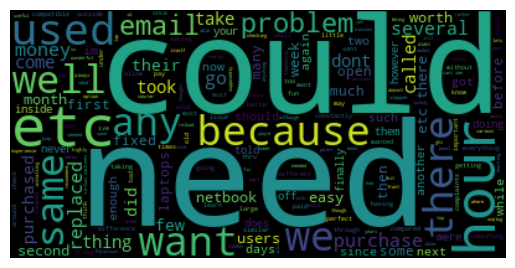

positive


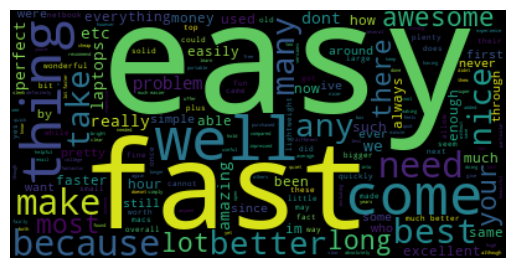

negative


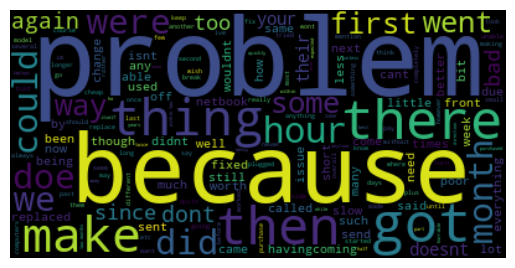

In [24]:
# Calculate term counts per polarity & sort by count desc
stop_words = term_frequency_df[term_frequency_df['freq_rate']>0.2]['word']

# We also want to include terms in these stop words as they may show up a lot in our dataset and does not express any emotion
terms =  set(re.sub('[^a-zA-Z\s]+', '', df[df['term'].isna() == False]['term'].str.cat(sep=' ').lower()).split())

# Add terms to list of stop words
stop_words = list(stop_words)
stop_words.extend(terms)

# Print word cloud for each polarity term, there maybe text from other term polarity included, but since we do not have a way to identify which words describe sentiment for which term
# We will just do this as a general overview
for x in df['polarity'].unique():
  if x != None:
    print(x)
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stop_words).generate(re.sub('[^a-zA-Z\s]+', '',df.loc[df['polarity']== x,'text'].str.cat(sep=' ').lower()))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Even with limitations, we can see some interesting words for each polarity here:
- positive: easy, fast, well, nice, better
- negative: problem, because
- neutral: could, need

These words are pretty aligned with the sentiment observed.

# 3. Terms

## 3.1. Terms per reviews

In [25]:
# Calculate length of text
df['text_length'] = df['text'].str.len()

# Calculate term counts per polarity & sort by count desc
term_counts_per_review = df.groupby('id').agg({'term':'count', 'text_length':'mean'}).reset_index()
term_counts = term_counts_per_review.groupby('term').agg({'id':'count', 'text_length':'mean'}).reset_index()
term_counts['pct'] = term_counts['id'] / len(term_counts_per_review) * 100

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=term_counts['term'], y=term_counts['pct'], name='% of total text'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=term_counts['term'], y=term_counts['text_length'], name="Avg. # of characters per text"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Terms per text"
)

# Set x-axis title
fig.update_xaxes(title_text="# of terms per text")

# Set y-axes titles
fig.update_yaxes(title_text="% of total text", secondary_y=False)
fig.update_yaxes(title_text="Avg. # of characters per text", secondary_y=True)

fig.show()

As we noticed earlier, more than 50% text have 0 term. This may reflect that people are being very generic and emotional without pointing out the exact topics they were discussing about. Other than 0 term text, we have majority of single term per text, which makes sense and would be good and easy for the algorithm as not so many aspects are being discussed at the same time. 

I also observed that the longer the text, the more terms were mentioned.

In [26]:
# Calculate list of unique
terms =  df[df['term'].isna() == False]['term'].unique() 
len(terms)

1048

Given the dataset of more than 3,000 texts, more than half having 0 term, we are seeing 1,048 unique terms being annotated for ~ 1,500 text. Thus, the terms are quite specific and looks like the ratio of them being mentioned in more than one text is pretty low. We may need to generalize these terms into segment, as that would be more useful and easier for end-user consumption.

## 3.2. Word counts per term

It would be useful to understand how most terms were extracted, whether they were single word or multi words.

In [27]:
term_length = [ len(x.split()) for x in terms]
fig = px.ecdf(term_length, marginal="histogram", width=600, height=600)
fig. update_layout(showlegend=False,
                   xaxis_title="# of words in terms",
                   yaxis_title="Term counts")

It seems like these terms are not very complex words, > 80% were made of under than 2 words.

In [28]:
terms = pd.DataFrame({'term': terms, 'term_length': term_length})

In [29]:
terms[terms['term_length'] == 2].head()

,term,term_length
1,battery life,2
2,service center,2
3,"""sales"" team",2
4,tech guy,2
9,start up,2


In [30]:
terms[terms['term_length'] == 3].head()

,term,term_length
16,hard drive ligh,3
26,suite of software,3
35,"30"" HD Monitor",3
46,Customer Service number,3
53,HP Technical Support,3


In [31]:
terms[terms['term_length'] == 4].head()

,term,term_length
41,clock in BIOS setup,4
47,talking to a technician,4
77,opening my Documents folder,4
95,"Office Max's ""Max Assurance""",4
100,Core Processing Unit temperatures,4


In [32]:
terms[terms['term_length'] == 5].head()

,term,term_length
33,Microsoft office for the mac,5
401,casing of the power cord,5
459,combined touch pad and clicker,5
499,Mac version of Microsoft Office,5
631,hook to my wireless network,5


In [33]:
terms[terms['term_length'] == 6].head()

,term,term_length
200,magnetic plug-in power charging power cord,6
798,hook up to other wireless networks,6
966,virus protection programs for a Mac,6


It looks like longer term is pretty much overlapped with shorter ones, while it is being more specific. Following the previous thoughts, segment these terms further will be very beneficial for further consumptions.

## 3.3. Most common words (in terms)

Since we know that our terms are very specific and do not repeat much in different text, and there are a lot of overlapped words between different terms. I will be looking at which words from these identified terms were mentioned the most.

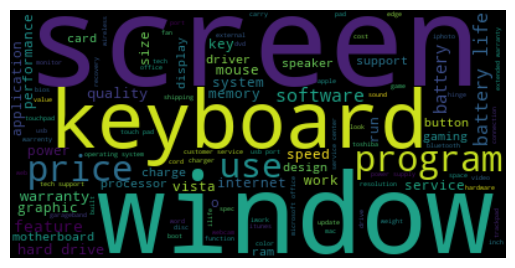

In [34]:
wordcloud = WordCloud().generate(df['term'].str.cat(sep=' ').lower())
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It looks like that `screen` and `window` appeared the most in these text as identified terms.
Let's look per polarity to see if there is any difference between polarity.

neutral


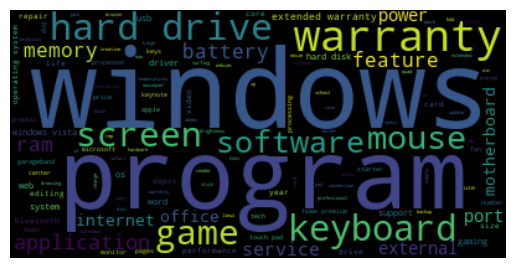

positive


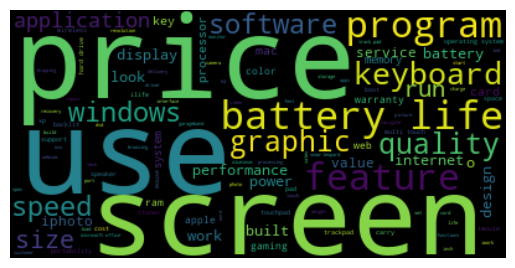

negative


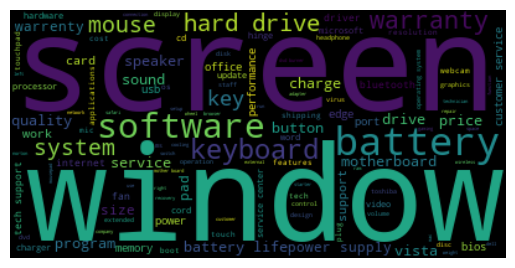

In [35]:
for x in df['polarity'].unique():
  if x != None:
    print(x)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(df.loc[df['polarity']== x,'term'].str.cat(sep=' ').lower())

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


- `program` & `window` seem edto be the key words for `neutral` terms.
- `user`, `price` & `screen` mostly appeared as `positive`.
- `window`, `screen` & `battery` seemed to be users' `negative` aspects.

# 4. Reviews' length

In [36]:
reviews = df['text'].unique()
review_length = [len(x.split()) for x in reviews]

fig = px.ecdf(review_length, marginal="histogram")
fig. update_layout(showlegend=False,
                   xaxis_title="# of words in reviews",
                   yaxis_title="Review counts")
fig.show()

80% text have under 20 words and maximum number of words are under 70 words, which would be ideal for NLP algorithm analyzing using word context which may have limits on maximum number of words per text like DistilBERT with 250 token limit.

# 5. Aspect extraction using pre-trained model

In [37]:
# Load pre-trained Named Entity Recognition (NER)
nlp = pipeline("ner", aggregation_strategy='simple')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Extract a few samples to test the algorithm
texts = df.drop_duplicates(subset='text')
input_texts = texts[:300]['text'].to_list()

# Extract named entities
ner_results_list = nlp(input_texts)
results = pd.DataFrame()

# Save terms for each sample text
for idx, ner_results in enumerate(ner_results_list):
    for entity in ner_results:
      results = pd.concat([results, pd.DataFrame([{'text': input_texts[idx], 'term': entity['word']}])], ignore_index=True)

In [39]:
# Collapse terms into array for the same text
results = results.groupby('text')['term'].agg(lambda x: x.tolist()).reset_index()
results

,text,term
0,"Acer has set me up with FREE recovery discs, when they are available since I asked.",[Acer]
1,"Acer was no help and Garmin could not determine the problem(after spending about 2 hours with me), so I returned it and purchased a Toshiba R700 that seems even nicer and I was able to load all of my software with no problem.","[Acer, Garmin, To, ##shiba, R700]"
2,Additional caveat: the base installation comes with some Toshiba-specific software that may or may not be to a user's liking.,[Toshiba]
3,"After a little more than a year of owning my MacBook Pro, the monitor has completely died.",[MacBook Pro]
4,"After talking it over with the very knowledgeable sales associate, I chose the MacBook Pro over the white MacBook.","[MacBook Pro, MacBook]"
...,...,...
83,the only fact i dont like about apples is they generally use safari and i dont use safari but after i install Mozzilla firfox i love every single bit about it.,[Mozzilla]
84,"My favorite by far, although the most expensive, was my Sony.",[Sony]
85,"Sony, Acer, Dell, Packard Bell and Toshiba.","[Sony, Acer, Dell, Packard Bell, Toshiba]"
86,Taking it back to Best Buy I found that a tiny plastic piece inside had broken (manuf issue).,[Best Buy]


In [40]:
# Join sample text and name entity extraction from pre-trained model
merge_df = pd.merge(results, texts, on='text', how='inner')
merge_df['same_term_check'] = merge_df['term_x'] == merge_df['term_y']
merge_df


,text,term_x,id,aspects,term_y,polarity,term_start,term_end,text_length,same_term_check
0,"Acer has set me up with FREE recovery discs, when they are available since I asked.",[Acer],1057,"{'term': ['recovery discs'], 'polarity': ['positive'], 'from': [29], 'to': [43]}",recovery discs,positive,29,43,83,False
1,"Acer was no help and Garmin could not determine the problem(after spending about 2 hours with me), so I returned it and purchased a Toshiba R700 that seems even nicer and I was able to load all of my software with no problem.","[Acer, Garmin, To, ##shiba, R700]",1259,"{'term': ['software'], 'polarity': ['positive'], 'from': [200], 'to': [208]}",software,positive,200,208,225,False
2,Additional caveat: the base installation comes with some Toshiba-specific software that may or may not be to a user's liking.,[Toshiba],2578,"{'term': ['base installation', 'software'], 'polarity': ['negative', 'negative'], 'from': [23, 74], 'to': [40, 82]}",base installation,negative,23,40,125,False
3,"After a little more than a year of owning my MacBook Pro, the monitor has completely died.",[MacBook Pro],1357,"{'term': ['monitor'], 'polarity': ['negative'], 'from': [62], 'to': [69]}",monitor,negative,62,69,90,False
4,"After talking it over with the very knowledgeable sales associate, I chose the MacBook Pro over the white MacBook.","[MacBook Pro, MacBook]",1722,"{'term': ['sales associate'], 'polarity': ['positive'], 'from': [50], 'to': [65]}",sales associate,positive,50,65,114,False
...,...,...,...,...,...,...,...,...,...,...
83,the only fact i dont like about apples is they generally use safari and i dont use safari but after i install Mozzilla firfox i love every single bit about it.,[Mozzilla],2541,"{'term': ['safari', 'safari', 'Mozzilla firfox'], 'polarity': ['negative', 'negative', 'positive'], 'from': [61, 83, 110], 'to': [67, 89, 125]}",safari,negative,61,67,159,False
84,"My favorite by far, although the most expensive, was my Sony.",[Sony],1863,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0,63,False
85,"Sony, Acer, Dell, Packard Bell and Toshiba.","[Sony, Acer, Dell, Packard Bell, Toshiba]",1861,"{'term': [''], 'polarity': [''], 'from': [0], 'to': [0]}",None,None,0,0,45,False
86,Taking it back to Best Buy I found that a tiny plastic piece inside had broken (manuf issue).,[Best Buy],942,"{'term': ['manuf'], 'polarity': ['negative'], 'from': [82], 'to': [87]}",manuf,negative,82,87,95,False


It looks like the purpose of NER may not fit what ABSA term extraction, as it is used to recognize entity, instead of aspect term. For example, the first record above, NER extract 'Acer' which is a brand name, while our dataset is suggesting an aspect about 'recovery discs' which is more likely related to the aspect being discussed in the text.

In [41]:
merge_df.same_term_check.sum()

0

As we noticed above, there was 0 matches on the term predicted by NER model and our training data. We have to find a way to manually tune the algorithm to extract aspects as we are interested in this project.